#note it takes around 16 min to load the whole colab

Here we make our own code to open a file directly from the google docs

In [0]:
# install gdown
import os.path as path
if not path.exists('food-com-recipes-and-user-interactions.zip'):
 !pip install gdown
 !gdown https://drive.google.com/uc?id=1CK99ASX3fsQ_KBY_RP7Nqms6dwsNs-jb
 !unzip food-com-recipes-and-user-interactions.zip
else :
 print('data is in places')

data is in places


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [0]:
df = pd.read_csv('new_data.csv')

In [0]:
df = df.rename(columns={'ingients': 'ing'})

In [0]:
#Checking the head of the dataframe
df.head()

,Unnamed: 0,rating,ing
0,0,4,pork chop flour garlic powder salt pepper seas...
1,1,4,extra virgin olive oil garlic cloves onion pan...
2,2,4,butter olive oil vidalia onion garlic cloves ...
3,3,4,olive oil onion salt pepper chicken stock gar...
4,4,4,pork chops salt and pepper garlic powder pork ...


Borrowed explanation from geeksforgeeks.com

"**Tokenization** is the process of tokenizing or splitting a string, text into a list of tokens. One can think of token as parts like a word is a token in a sentence, and a sentence is a token in a paragraph."

Tokenizing the text, here we get the help from tweet tokenizer

In [0]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
df['Tokens'] = df['ing'].map(lambda textline: [tag for tag in tknzr.tokenize(textline)])
tokens = df['Tokens'].copy()

Tokenizing the text with normal word_tokenize

In [0]:
from nltk.tokenize import word_tokenize, sent_tokenize
import multiprocessing
p = multiprocessing.Pool()


dftok = (word_tokenize, df.ing)

##BOW - Bag-of-words by using vectorizer

Due to fact that machines don't read text the same way humans do, the text must be converted into numeric structure. A common way to do this is through the use of Bag of Words. BoW splits words into pieces of text into tokens with no regard to word order. Afterwards the model is capable of counting the frequency a word is present in the text and assigns a weight proportional to this frequency.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = df.ing
vectorizer = CountVectorizer()
BOW = vectorizer.fit_transform(corpus)

Here we see that out of the 60,000 recipes and the ingredients used in them, we have almost 3000 different words

In [0]:
print(len(vectorizer.get_feature_names()))

2956


Next we will use LogisticRegression to see the weights of each word in the classes in our case recipes rated from 0-5 stars with the help of eli5

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [0]:
vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

In [0]:
model.fit(df['ing'], df['rating'])

In [0]:
!pip -q install eli5
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=30)

     |████████████████████████████████| 112kB 2.9MB/s 


/usr/local/lib/python3.6/dist-packages/eli5/base_utils.py:28: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  init_args = inspect.getargspec(class_.__init__)
/usr/local/lib/python3.6/dist-packages/eli5/base_utils.py:28: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  init_args = inspect.getargspec(class_.__init__)
/usr/local/lib/python3.6/dist-packages/eli5/base_utils.py:28: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  init_args = inspect.getargspec(class_.__init__)
/usr/local/lib/python3.6/dist-packages/eli5/base_utils.py:28: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  init_args = inspect.getargspec(class_.__init__)
/usr/local/lib/python3.6/dist-packages/eli5/base_uti

##TF-IDF - Term Frequency: Inverse Document Frequency

TF-IDF(Term frequency – inverse document frequency)  is another method through which we can judge the topic of a text through the words it contains. Compared to BoW, TF-IDF measures the relevance of the words, not their frequency. TF is the result of using BoW while IDF systematically discounts the words that appear too often. As a result we will be left with only the most frequent and distinctive words as markers


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
recipes_bow_tf = vectorizer.fit_transform(corpus)

##LSA - Latent Semantic Analysis (BOW + TF-IDF) Dimensional reduction

Latent Semantic Analysis(LSA) is a technique which retrieves information that is then analyzed in order to identify existing patterns in the text and the relationship between them.


In [0]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

recipes_bow_tf = sparse_random_matrix(250, 250, density=0.01, random_state=42)
svd = TruncatedSVD(n_components=90, n_iter=7, random_state=42)
X_lsa = svd.fit_transform(recipes_bow_tf)

we managed to reduce dimensionality 

In [0]:
len(X_lsa)

250

##LDA - model

LDA is a topic model and it is used in order to find the abstract topics that might occur in a document. The way it works is that it builds a topic per document model and words per topic model, which are modeled as Dirichlet distributions.


We do some neccessary steps in order to make LDA model learn our data

In [0]:
!pip install pyLDAvis

In [0]:
import pyLDAvis.gensim
%matplotlib inline
pyLDAvis.enable_notebook()

In [0]:
import spacy
nlp = spacy.load("en")

In [0]:
from gensim.corpora.dictionary import Dictionary
dictionary = Dictionary(tokens)

In [0]:
corpus = [dictionary.doc2bow(doc) for doc in tokens]

Here the LDA model is learning our corpus

In [0]:
from gensim.models import LdaMulticore
lda_model = LdaMulticore(corpus, id2word=dictionary,  num_topics=10, workers = 2, passes=10)

Here we see something like clusters - we see a connections in these words

In [0]:
lda_model.print_topics(-1)

[(0,
  '0.074*"cheese" + 0.071*"corn" + 0.045*"cream" + 0.030*"beans" + 0.030*"cheddar" + 0.029*"onion" + 0.026*"sour" + 0.024*"rice" + 0.023*"tortillas" + 0.023*"jack"'),
 (1,
  '0.095*"flour" + 0.093*"sugar" + 0.074*"baking" + 0.069*"salt" + 0.054*"butter" + 0.050*"powder" + 0.042*"vanilla" + 0.038*"eggs" + 0.036*"milk" + 0.031*"allpurpose"'),
 (2,
  '0.064*"pepper" + 0.064*"fresh" + 0.060*"olive" + 0.059*"oil" + 0.051*"salt" + 0.046*"garlic" + 0.033*"dried" + 0.027*"parsley" + 0.024*"cloves" + 0.021*"ground"'),
 (3,
  '0.080*"ground" + 0.073*"cinnamon" + 0.059*"sugar" + 0.044*"nutmeg" + 0.026*"juice" + 0.024*"lemon" + 0.024*"apple" + 0.022*"pumpkin" + 0.021*"water" + 0.021*"butter"'),
 (4,
  '0.061*"sauce" + 0.041*"oil" + 0.040*"juice" + 0.037*"soy" + 0.035*"sugar" + 0.034*"garlic" + 0.032*"pepper" + 0.032*"vinegar" + 0.031*"chicken" + 0.027*"fresh"'),
 (5,
  '0.060*"pepper" + 0.053*"salt" + 0.049*"cheese" + 0.044*"cream" + 0.041*"onion" + 0.035*"butter" + 0.034*"milk" + 0.029*"soup

In [0]:
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)

And here we can nicely see each topic with cluster, some of them are obviously baking recipes, some for lemonades, some for grilling and some are mix

In [0]:
pyLDAvis.display(lda_display)

##Unsupervised Machine Learning

Again we do some steps neccessary in order to make the Clusters. Like fitting the model to corpus, making LSI model and using gensim similarities

In [0]:
from gensim.models.tfidfmodel import TfidfModel

In [0]:
tfidf = TfidfModel(corpus)

In [0]:
tfidf_corpus = tfidf[corpus]

In [0]:
# Just like before, we import the model
from gensim.models.lsimodel import LsiModel

lsi = LsiModel(tfidf_corpus, num_topics=100)

In [0]:
lsi_corpus = lsi[tfidf_corpus]

In [0]:
from gensim.similarities import MatrixSimilarity

# Create the document-topic-matrix
document_topic_matrix = MatrixSimilarity(lsi_corpus)
document_topic_matrix_ix = document_topic_matrix.index

In [0]:
sims = document_topic_matrix[lsi_corpus[0]]
sims = sorted(enumerate(sims), key=lambda item: -item[1])
print(sims)

We use this to make less neighbors for clustering 

In [0]:
import umap
embeddings = umap.UMAP(n_neighbors=15, metric='cosine').fit_transform(document_topic_matrix_ix)

In [0]:
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters = 10)
clusterer.fit(document_topic_matrix_ix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Here we plot the clusters into one scatterplot

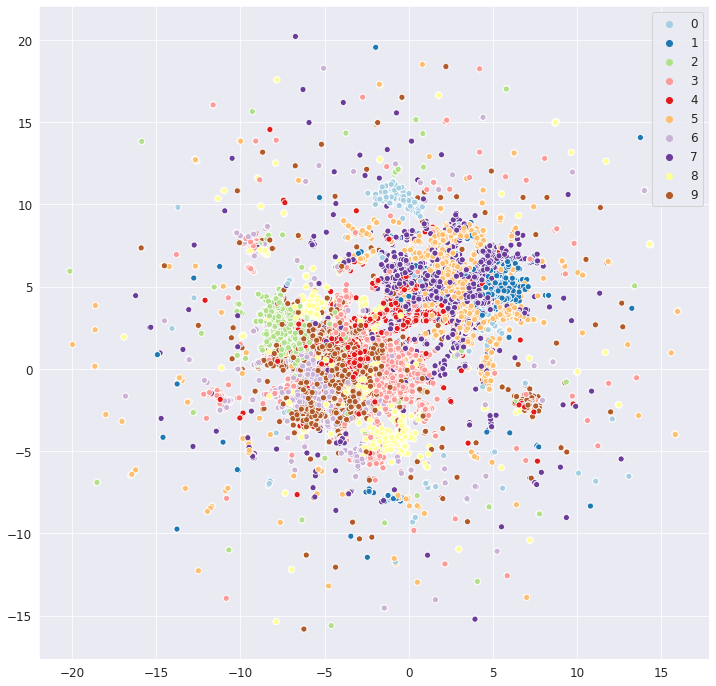

In [0]:
# Plotting things
import seaborn as sns
sns.set_style("darkgrid")

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(12,12))
g = sns.scatterplot(*embeddings.T,
                    #reduced[:,0],reduced[:,1],
                   hue=clusterer.labels_,
                    palette="Paired",
                   legend='full')

In [0]:
# Let's explore the clusters, that should actually correlate with topics found by LDA
df['cluster'] = clusterer.labels_

This should be the recipes and their ingrediences that were found in different topics, sorted by LDA analysis

In [0]:
df[df['cluster'] == 2]['ing']

2        butter olive oil vidalia onion garlic cloves  ...
23       lean pork garlic cloves cornstarch sugar soy s...
39        beans flank steak soy sauce cornstarch chines...
70       garlic cloves soy sauce water honey vegetable ...
74       chicken wings margarine soy sauce  sugar water...
                               ...                        
59957    cornstarch worcestershire sauce top sirloin st...
59974    pork chops onion celery garlic ginger salt pep...
59975    whole chickens teriyaki sauce chinese five spi...
59980    eggs chinese vegetables oil  onions beef broth...
59993      pork spareribs salt pepper barbecue sauce onion
Name: ing, Length: 3990, dtype: object

##Train a word-embedding model of your choice (Word2Vec, GloVe or Fasttext) 

This module implements the word2vec family of algorithms, using highly optimized C routines, data streaming and Pythonic interfaces.

In [0]:
from gensim.models import Word2Vec
import logging
from gensim.models.phrases import Phrases, Phraser
phrases = Phrases(tokens, min_count=5, threshold=10)
bigram = Phraser(phrases)
tokens_phrases = tokens.map(lambda t: bigram[t])
model_paprika = Word2Vec(tokens_phrases, size=100, window=5, min_count=5, workers=4, iter=3)

Here we make our model paprika and we try to find out which are the most similar words from this text with our chosen word paprika - the results speak for themselves :-P 

In [0]:
model_paprika.wv.most_similar('paprika')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('cayenne', 0.7914016246795654),
 ('pepper', 0.6527678370475769),
 ('cumin', 0.6453433036804199),
 ('chili', 0.6301818490028381),
 ('ancho_chile', 0.6186747550964355),
 ('seed', 0.617232620716095),
 ('coarse', 0.6162411570549011),
 ('coriander', 0.6096932888031006),
 ('oregano', 0.6072298288345337),
 ('powder', 0.606373131275177)]

# Machine Learning - Supervised


###Model preparation

In [0]:
# Defining the dependent variable. What are we looking for? 
y = df['rating']


# Importing the train-test split function.
from sklearn.model_selection import train_test_split

# Making the split. We keep 75% for training and 25% for test.
X_train, X_test, y_train, y_test = train_test_split(BOW, y, test_size = 0.25, random_state=42)

In [0]:
print( X_train.shape, y_train.shape)
print( X_test.shape, y_test.shape)

(45000, 2956) (45000,)
(15000, 2956) (15000,)


##Logistic Regression

In [0]:
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score

In [0]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

scores = cross_val_score(model, X_train, y_train, cv = 5)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(model.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.21


Logistic regression gives us only 21% true prediction for this model, which is very, very low. We will contemplate about this result in stakeholders report and in exam

In [0]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.20      0.20      0.20      2452
           1       0.24      0.31      0.27      2545
           2       0.20      0.16      0.18      2564
           3       0.19      0.18      0.19      2472
           4       0.21      0.19      0.20      2539
           5       0.21      0.22      0.21      2428

    accuracy                           0.21     15000
   macro avg       0.21      0.21      0.21     15000
weighted avg       0.21      0.21      0.21     15000



Preparing to print a bit fancier confusion matrix

In [0]:

!pip install -U mlxtend
# Import the confusion matrix plotter module
from mlxtend.plotting import plot_confusion_matrix

# We will also import sklearns confusion matrix module (makes it easy to produce a confusion matrix)
# It's actually just a cross-tab of predicted vs. real values
from sklearn.metrics import confusion_matrix

The number is the number of stars the recipe got 

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7facf94a6160>)

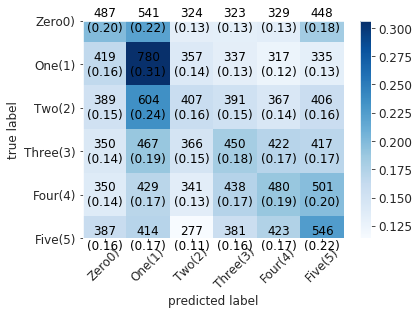

In [0]:
classNames = ["Zero0)","One(1)","Two(2)", "Three(3)", "Four(4)", "Five(5)"]
plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names = classNames)

We can see that the prediction for each star are very low, explanation will be in stakeholders report 

##MultinomialNB

**preparation**

Here we will try a different Model, maybe it will give us a better conclusion

In [0]:
y = df["rating"]
X_train, X_test, y_train, y_test = train_test_split(df["ing"], y, test_size=0.33, random_state=53)
count_vectorizer = CountVectorizer()
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)


In [0]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

# Print the first 5 vectors of the tfidf training data
print(tfidf_train.A[:5])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
# Following some of the steps from NLP lectures and colabs provided

# Create the CountVectorizer DataFrame: count_df
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

# Print the head of count_df
print(count_df.head())

# Print the head of tfidf_df
print(tfidf_df.head())

# Calculate the difference in columns: difference
difference = set(count_df.columns) - set(tfidf_df.columns)
print(difference)

# Check whether the DataFrames are equal
print(count_df.equals(tfidf_df))

   10  10inch  10minute  10x  ...  ziploc  ziti  zucchini  zwieback
0   0       0         0    0  ...       0     0         0         0
1   0       0         0    0  ...       0     0         0         0
2   0       0         0    0  ...       0     0         0         0
3   0       0         0    0  ...       0     0         0         0
4   0       0         0    0  ...       0     0         0         0

[5 rows x 2748 columns]
    10  10inch  10minute  10x  ...  ziploc  ziti  zucchini  zwieback
0  0.0     0.0       0.0  0.0  ...     0.0   0.0       0.0       0.0
1  0.0     0.0       0.0  0.0  ...     0.0   0.0       0.0       0.0
2  0.0     0.0       0.0  0.0  ...     0.0   0.0       0.0       0.0
3  0.0     0.0       0.0  0.0  ...     0.0   0.0       0.0       0.0
4  0.0     0.0       0.0  0.0  ...     0.0   0.0       0.0       0.0

[5 rows x 2712 columns]
{'back', 'without', 'no', 'all', 'after', 'with', 'one', 'ie', 'on', 'thin', 'and', 'con', 'made', 'the', 'any', 'fire', 'mill',

In [0]:
# Here we will train our MultinomialNB model
# Import the necessary modules
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)



0.21378787878787878


Again we see, that the score is almost the same as Logistic Regression, its very low. 

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7facedda8c18>)

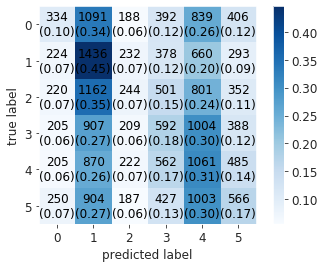

In [0]:
confmatrix = confusion_matrix(y_test,pred)
plot_confusion_matrix(conf_mat=confmatrix,
colorbar=True,
show_absolute=True,
show_normed=True)

And again we can see each of the label in confusion matrix, and the results are very low as you can see